# Salinity comparison with MEOP data

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as col
from scipy import interpolate

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/Weddell_connectivity/obs/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44325/status,
Dashboard: /proxy/44325/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37811,Workers: 4
Dashboard: /proxy/44325/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:43251,Total threads: 4
Dashboard: /proxy/38267/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:42331,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
ryf = '01deg_jra55v13_ryf9091'
cycle2 = '01deg_jra55v140_iaf_cycle2'
cycle3 = '01deg_jra55v140_iaf_cycle3'

start_time='2150-01-01'
end_time='2159-12-31'

lon_slice  = slice(-120, -50)
lat_slice  = slice(-75.5,-60)

In [4]:
# topography data for plotting:
ht = cc.querying.getvar(ryf,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

# bottom cell indices:
kmt = cc.querying.getvar(ryf,'kmt',master_session, n=-1)
kmt = kmt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
kmt = kmt.fillna(1.0).astype(int) - 1
kmt.load()

fontsize=16

In [5]:
# Shelf mask to check if profiles are on shelf or not:

# Note this is on the t grid
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_map = np.nan_to_num(shelf_mask)
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
shelf_map = shelf_map.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

## Select out obs profiles in correct region:

In [6]:
%%time

# do some testing to see which seal data is in the right region:
# Need to consider profiles from Brazil, Germany, UK, USA
# I think the interpolated data is fine to use here, because I only want profiles < 1000m.

path2files   = '/g/data/v45/akm157/data/meop_seal_data/'
FileList = glob(path2files+'*/DATA_ncARGO/*')
FileList.sort()

WAP_FileList = []
for file in FileList:
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    # check if in West Antarctic Peninsula box:
    WAP_box=lat.where(lon>-120).where(lon<-50).where(lat<-60).dropna(dim='N_PROF')
    if len(WAP_box)>0:
        WAP_FileList += [file]

CPU times: user 23.5 s, sys: 2.3 s, total: 25.8 s
Wall time: 27.1 s


In [7]:
%%time

# Now go through the profiles in the WAP box and select out all profiles on the shelf:
# We also need salinity, to convert in situ temp to conservative temp.

# I have checked TEMP_ADJUSTED_QC,PSAL_ADJUSTED_QC,PRES_ADJUSTED_QC=1 for all profiles used.

nprofiles = 22312 # 47636
ndepth = 22
temp = np.zeros((nprofiles,ndepth))
#saltQC = np.zeros((nprofiles,ndepth))
#presQC = np.zeros((nprofiles,ndepth))
salt = np.zeros((nprofiles,ndepth))
pres = np.zeros((nprofiles,ndepth))
lon_obs = np.zeros((nprofiles))
lat_obs = np.zeros((nprofiles))
date = []
profile_count = 0

file_count = 1
for file in WAP_FileList:
    print('file '+str(file_count)+'/'+str(len(WAP_FileList)))
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    # go through each profile and find nearest model grid point:
    for profile in range(len(lat)):
        # NOTE THAT LONGITUDE IS NOT ADJUSTED FOR THE MODEL RANGE HERE, BECAUSE RANGE ON PENINSULA IS OK
        # BUT THIS WILL NOT WORK ELSEWHERE!!
        on_shelf = shelf_map.sel(xt_ocean=lon[profile],method='nearest').sel(yt_ocean=lat[profile],method='nearest')
        if on_shelf>0:
            # check temp has at least 2 data points:
            temp_profile = profile_data.TEMP_ADJUSTED[profile]
            if len(np.where((temp_profile!=0.)&(~np.isnan(temp_profile)))[0]) > 2:
                # check the dive reached at least 200 dbar:
                pres_profile = profile_data.PRES_ADJUSTED[profile]
                if pres_profile.max() >= 450:
                    date = np.append(date,profile_data.JULD[profile])
                    # save profile:
                    lat_obs[profile_count] = lat[profile]
                    lon_obs[profile_count] = lon[profile]
                    # find depth of profile:
                    nlevels = len(profile_data.PRES_ADJUSTED[profile])
                    temp[profile_count,:nlevels] = temp_profile
                    salt_profile = profile_data.PSAL_ADJUSTED[profile]
                    salt[profile_count,:nlevels] = salt_profile
                    #saltQC_profile = profile_data.PSAL_ADJUSTED_QC[profile]
                    #saltQC[profile_count,:nlevels] = saltQC_profile
                    #presQC_profile = profile_data.PRES_ADJUSTED_QC[profile]
                    #presQC[profile_count,:nlevels] = presQC_profile
                    pres[profile_count,:nlevels] = pres_profile
                    profile_count += 1
    file_count += 1
# Wall time: 

file 1/165
file 2/165
file 3/165
file 4/165
file 5/165
file 6/165
file 7/165
file 8/165
file 9/165
file 10/165
file 11/165
file 12/165
file 13/165
file 14/165
file 15/165
file 16/165
file 17/165
file 18/165
file 19/165
file 20/165
file 21/165
file 22/165
file 23/165
file 24/165
file 25/165
file 26/165
file 27/165
file 28/165
file 29/165
file 30/165
file 31/165
file 32/165
file 33/165
file 34/165
file 35/165
file 36/165
file 37/165
file 38/165
file 39/165
file 40/165
file 41/165
file 42/165
file 43/165
file 44/165
file 45/165
file 46/165
file 47/165
file 48/165
file 49/165
file 50/165
file 51/165
file 52/165
file 53/165
file 54/165
file 55/165
file 56/165
file 57/165
file 58/165
file 59/165
file 60/165
file 61/165
file 62/165
file 63/165
file 64/165
file 65/165
file 66/165
file 67/165
file 68/165
file 69/165
file 70/165
file 71/165
file 72/165
file 73/165
file 74/165
file 75/165
file 76/165
file 77/165
file 78/165
file 79/165
file 80/165
file 81/165
file 82/165
file 83/165
file 84/165
f

## Interpolate MEOP profiles onto model depth grid and convert to conservative temp:


In [11]:
# convert to absolute salinity:
from gsw import SA_from_SP
salt_abs = SA_from_SP(salt,pres,np.tile(lon_obs,(ndepth,1)).swapaxes(0,1),np.tile(lat_obs,(ndepth,1)).swapaxes(0,1))

In [12]:
# convert to conservative temp:
from gsw import CT_from_t
temp_conservative = CT_from_t(salt_abs,temp,pres)

In [13]:
# convert pressure to depth:
from gsw import z_from_p
z = -z_from_p(pres,np.tile(lat_obs,(ndepth,1)).swapaxes(0,1))

In [14]:
%%time
# Interpolate to model point nearest 450m:
st_ocean = cc.querying.getvar(ryf,'st_ocean' , master_session,n=1)
model_depth = st_ocean.sel(st_ocean=450,method='nearest')

temp_interp = np.zeros((nprofiles))
salt_interp = np.zeros((nprofiles))

max_profile_depth = z.max(axis=1)

for profile in range(nprofiles):
    # select out available pressure range of data:
    z_profile = z[profile,:][z[profile,:]>0]
    temp_profile = temp_conservative[profile,:][z[profile,:]>0]
    salt_profile = salt_abs[profile,:][z[profile,:]>0]
    # check profile is deep enough:
    # keep if within 70m of model depth (468.4475154m)
    if max_profile_depth[profile] < model_depth-70:
        # else set all to nans:
        temp_profile = temp_profile*np.nan
        salt_profile = salt_profile*np.nan
    
    f = interpolate.interp1d(z_profile,temp_profile,bounds_error=False,fill_value="extrapolate")
    g = interpolate.interp1d(z_profile,salt_profile,bounds_error=False,fill_value="extrapolate")
    temp_interp[profile] = f(model_depth)
    salt_interp[profile] = g(model_depth)
# Wall time: 10.2 s

CPU times: user 14.6 s, sys: 1.38 s, total: 16 s
Wall time: 14.8 s


In [15]:
lon_obs = lon_obs[~np.isnan(temp_interp)]
lat_obs = lat_obs[~np.isnan(temp_interp)]

In [16]:
# date = date[~np.isnan(temp_interp)]
meop_temp = temp_interp[~np.isnan(temp_interp)]
meop_salt = salt_interp[~np.isnan(temp_interp)]

Text(0.5, 0, 'Longitude')

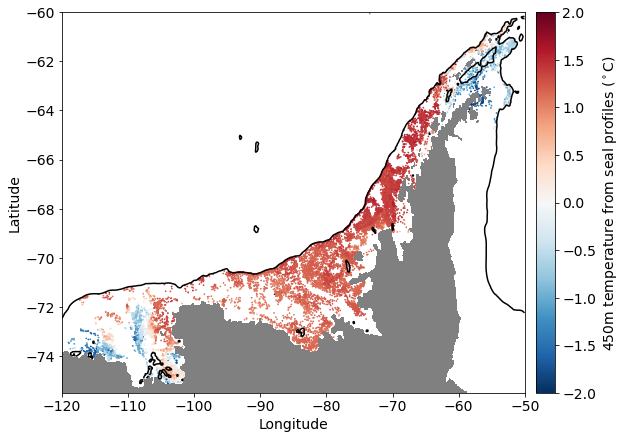

In [17]:
fontsize = 14
depth_slice = 450

plt.figure(figsize=(10,7))
sc = plt.scatter(lon_obs,lat_obs,c=meop_temp,s=.5,cmap='RdBu_r',vmin=-2,vmax=2)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.xlim(-120,-50)
plt.ylim(-75.5,-60)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)

Text(0.5, 0, 'Longitude')

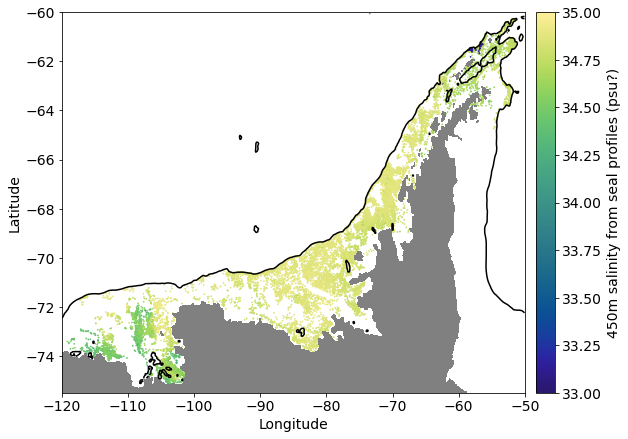

In [27]:
import cmocean # salinity colour bar
fontsize = 14
depth_slice = 450

plt.figure(figsize=(10,7))
sc = plt.scatter(lon_obs,lat_obs,c=meop_salt,s=.5,cmap=cmocean.cm.haline,vmin=33,vmax=35)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m salinity from seal profiles (psu?)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.xlim(-120,-50)
plt.ylim(-75.5,-60)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)

## Save interpolated seal data:

In [15]:
[len(meop_temp), len(date)]

[20138, 22312]

In [30]:
[len(meop_salt), len(date)]

[20138, 22312]

In [31]:
data_nr = len(meop_temp) # length of all profiles -> 20138 = I have that many different profiles
meop_temp = xr.DataArray(meop_temp, coords = [np.arange(data_nr)], dims = ['profile_number'], name = 'seal profile cons. temp. interpolated onto model depth grid closest to 450m')
meop_salt = xr.DataArray(meop_salt, coords = [np.arange(data_nr)], dims = ['profile_number'], name = 'seal profile abs. salinity. interpolated onto model depth grid closest to 450m')

lon_obs   = xr.DataArray(lon_obs, coords = [np.arange(data_nr)], dims = ['profile_number'], name = 'longitude of seal profiles')
lat_obs   = xr.DataArray(lat_obs, coords = [np.arange(data_nr)], dims = ['profile_number'], name = 'latitude of seal profiles')
date      = xr.DataArray(date, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'date of seal profiles')

ds = xr.Dataset({'meop_temp': meop_temp,'lon_obs':lon_obs,'lat_obs':lat_obs,'date':date,
                 'meop_salt': meop_salt,'lon_obs':lon_obs,'lat_obs':lat_obs,'date':date})
outpath = '/g/data/e14/mv7494/seal_data_comparison/' + 'WAP_seal_profiles_'+str(depth_slice)+'m_depth_ACCESS-OM2-01.nc'
ds.to_netcdf(outpath)

## Open saved seal data:

In [49]:
# outpath = '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091/seal_data_comparison/WAP_MEOP_profiles_interpolated.nc'
profile_data = xr.open_dataset(outpath)
lat_obs = profile_data.lat_obs
lon_obs = profile_data.lon_obs
meop_temp = profile_data.meop_temp

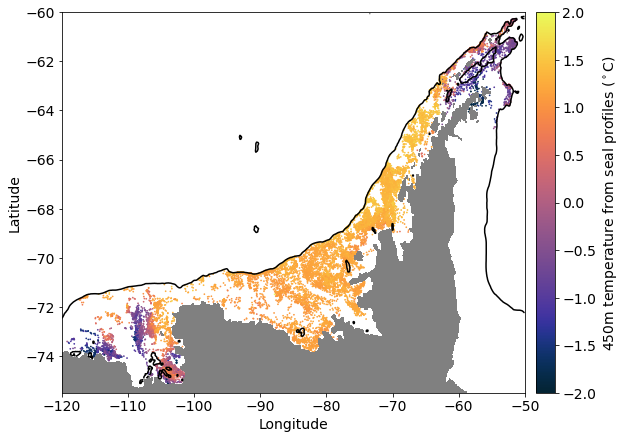

In [50]:
# plot unbinned data:
fontsize = 14

plt.figure(figsize=(10,7))
sc = plt.scatter(lon_obs,lat_obs,c=meop_temp,s=.5,cmap=cmocean.thermal,vmin=-2,vmax=2)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.xlim(-120,-50)
plt.ylim(-75.5,-60)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)

figure_path = figdir+'/seal_temp_map_'+str(depth_slice)+'m.png'
# plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

## Bin seal data into lat/lon bins:
Redo this step, but first delete any obs profiles where model profiles are nan.

In [51]:
# first set profiles that are land in the model to nans:
# Note there is a threshold of ~ 10 km used here:
meop_temp = meop_temp.where(~np.isnan(ryf_temp),drop=True)
lon_obs = lon_obs.where(~np.isnan(ryf_temp),drop=True)
lat_obs = lat_obs.where(~np.isnan(ryf_temp),drop=True)

# need to assign lat/lon coords for binning:
meop_temp = meop_temp.assign_coords({'lon':lon_obs,'lat':lat_obs})

# set up new bins:
lon_bins = np.arange(-121, -49, .4)
lat_bins = np.arange(-76, -60, .15) 

lon_mid = (lon_bins[1:] + lon_bins[:-1])/2
lat_mid = (lat_bins[1:] + lat_bins[:-1])/2

# single slice:
binned_meop_temp = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'], name = 'binned meop temperature data')
                                                      
for i in range(len(lon_bins)-1):
    if i%10 == 0:
        print('lon bin '+str(i)+'/'+str(len(lon_bins)-1))
    for j in range(len(lat_bins)-1):
        bin_mask = meop_temp.where(meop_temp.lon <= lon_bins[i+1]).where(meop_temp.lon > lon_bins[i])\
            .where(meop_temp.lat <= lat_bins[j+1]).where(meop_temp.lat > lat_bins[j]) * 0 + 1
        binned_meop_temp[j,i] = (meop_temp * bin_mask).mean(dim = 'profile_number')

ds = xr.Dataset({'binned_meop_temp': binned_meop_temp})
outpath = '/g/data/v45/akm157/model_data/access-om2/'+ryf+'/seal_data_comparison/WAP_MEOP_profiles_binned_coarse.nc'
ds.to_netcdf(outpath)

NameError: name 'ryf_temp' is not defined

## Get model grid data and temperature climatology:

In [55]:
# for comparing seal data to IAF:
cycle2 = '01deg_jra55v140_iaf_cycle2'
cycle3 = '01deg_jra55v140_iaf_cycle3'

depth_slice = 450

start_time='2005-02-01'
end_time='2015-10-31'

temp_cycle2 = cc.querying.getvar(cycle2,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_cycle2 = temp_cycle2.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')
temp_cycle2 = temp_cycle2.load()

temp_cycle3 = cc.querying.getvar(cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_cycle3 = temp_cycle3.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')
temp_cycle3 = temp_cycle3.load()

## Select out model data from same months and locations as seal profiles:
Repeat this to find closest _non-land_ model grid point.

In [56]:
nprofiles = len(date)
model_temp_profiles = np.zeros((nprofiles))
model_lat_profiles = np.zeros(nprofiles)
model_lon_profiles = np.zeros(nprofiles)

# find corresponding model profiles:
for profile in range(nprofiles):
    if profile%1000 == 0:
        print('profile '+str(profile)+'/'+str(nprofiles))
    profile_month = date[profile].dt.month.values
    
    # for RYF:
    #model_temp_profiles[profile] = temp_ryf.sel(month=profile_month).sel(xt_ocean=lon_obs[profile],method='nearest')\
    #    .sel(yt_ocean=lat_obs[profile],method='nearest')
    
    ## for IAF:
    profile_year = date[profile].dt.year.values
    start_date = str(profile_year)+'-'+str(profile_month)
    end_date = str(profile_year)+'-'+str(profile_month)
    model_temp_profiles[profile] = temp_cycle3.sel(time=slice(start_date,end_date)).sel(xt_ocean=lon_obs[profile],method='nearest')\
        .sel(yt_ocean=lat_obs[profile],method='nearest')
    ## end for IAF
    
    # check if it has selected a land point:
    '''if np.isnan(model_temp_profiles[profile]):
        # IAF
        temp_slice = temp_cycle2.sel(time=slice(start_date,end_date)).squeeze()
        # RYF
        #temp_slice = temp_ryf.sel(month=profile_month).squeeze()
        # fill in nans once back in y direction, once back in x direction then forwards once in both directions:
        temp_slice = temp_slice.bfill(dim='yt_ocean',limit=1).bfill(dim='xt_ocean',limit=1)\
            .ffill(dim='yt_ocean',limit=1).ffill(dim='xt_ocean',limit=1)\
            .bfill(dim='yt_ocean',limit=1).bfill(dim='xt_ocean',limit=1)\
            .ffill(dim='yt_ocean',limit=1).ffill(dim='xt_ocean',limit=1)
        # repeat:
        temp_slice = temp_slice.bfill(dim='yt_ocean',limit=1).bfill(dim='xt_ocean',limit=1)\
            .ffill(dim='yt_ocean',limit=1).ffill(dim='xt_ocean',limit=1)\
            .bfill(dim='yt_ocean',limit=1).bfill(dim='xt_ocean',limit=1)\
            .ffill(dim='yt_ocean',limit=1).ffill(dim='xt_ocean',limit=1)
        model_temp_profiles[profile] = temp_slice.sel(xt_ocean=lon_obs[profile],method='nearest')\
            .sel(yt_ocean=lat_obs[profile],method='nearest')
        # This expands everything in  at least 2 grid points (i.e. ~ 10 km). 
        # If there is no matching grid point after that, we will nan the model profile later to match.'''
    
    model_lon_profiles[profile] = xt_ocean.sel(xt_ocean=lon_obs[profile],method='nearest')
    model_lat_profiles[profile] = yt_ocean.sel(yt_ocean=lat_obs[profile],method='nearest')

# save data:
model_temp_profiles = xr.DataArray(model_temp_profiles, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'model profiles')
model_lon_profiles = xr.DataArray(model_lon_profiles, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'longitude of model profiles')
model_lat_profiles = xr.DataArray(model_lat_profiles, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'latitude of model profiles')

ds = xr.Dataset({'model_temp_profiles': model_temp_profiles,'model_lon_profiles':model_lon_profiles,'model_lat_profiles':model_lat_profiles})
#outpath = '/g/data/v45/akm157/model_data/access-om2/'+ryf+'/seal_data_comparison/WAP_model_profiles.nc'
#outpath = '/g/data/v45/akm157/model_data/access-om2/'+ryf+'/seal_data_comparison/WAP_model_profiles_avoid_land.nc'
outpath = '/g/data/v45/akm157/model_data/access-om2/'+cycle3+'/seal_data_comparison/WAP_model_profiles.nc'
#outpath = '/g/data/v45/akm157/model_data/access-om2/'+cycle2+'/seal_data_comparison/WAP_model_profiles_avoid_land.nc'
#outpath = '/g/data/v45/akm157/model_data/access-om2/'+ryf+'/seal_data_comparison/WAP_model_profiles_1950-1959.nc'
# ds.to_netcdf(outpath)

profile 0/22312


AttributeError: 'numpy.ndarray' object has no attribute 'sel'

## Bin model profiles into lat/lon bins:
To do: Change binning to use obs lat/lon, not model lat/lon, because otherwise the maps are not comparable.

In [10]:
# IAF binning:

# open saved model profiles:
#outpath = '/g/data/v45/akm157/model_data/access-om2/'+cycle3+'/seal_data_comparison/WAP_model_profiles_avoid_land.nc'
outpath = '/g/data/v45/akm157/model_data/access-om2/'+cycle3+'/seal_data_comparison/WAP_model_profiles.nc'
profile_data = xr.open_dataset(outpath)
lat_model = profile_data.model_lat_profiles
lon_model = profile_data.model_lon_profiles
cycle3_temp = profile_data.model_temp_profiles
cycle3_temp = cycle3_temp.load()
outpath = '/g/data/v45/akm157/model_data/access-om2/'+cycle2+'/seal_data_comparison/WAP_model_profiles.nc'
#outpath = '/g/data/v45/akm157/model_data/access-om2/'+cycle2+'/seal_data_comparison/WAP_model_profiles_avoid_land.nc'
profile_data = xr.open_dataset(outpath)
lat_model = profile_data.model_lat_profiles
lon_model = profile_data.model_lon_profiles
cycle2_temp = profile_data.model_temp_profiles
cycle2_temp = cycle2_temp.load()

# Take mean of cycle2 and cycle3:
#iaf_temp = (cycle3_temp+cycle2_temp)/2
# Cycle 3 only:
iaf_temp = cycle3_temp

# need to assign lat/lon coords for binning:
#iaf_temp = iaf_temp.assign_coords({'lon':lon_model,'lat':lat_model})
# Changed here: Use obs lat/lon, not model, otherwise they are in different locations!
iaf_temp = iaf_temp.assign_coords({'lon':lon_obs,'lat':lat_obs})

# set up new bins:
lon_bins = np.arange(-121, -49, .4)
lat_bins = np.arange(-76, -60, .15) 

lon_mid = (lon_bins[1:] + lon_bins[:-1])/2
lat_mid = (lat_bins[1:] + lat_bins[:-1])/2

# single slice:
binned_iaf_temp = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'], name = 'binned IAF temperature data')
                                                      
for i in range(len(lon_bins)-1):
    if i%20 == 0:
        print('lon bin '+str(i)+'/'+str(len(lon_bins)-1))
    for j in range(len(lat_bins)-1):
        bin_mask = iaf_temp.where(iaf_temp.lon <= lon_bins[i+1]).where(iaf_temp.lon > lon_bins[i])\
            .where(iaf_temp.lat <= lat_bins[j+1]).where(iaf_temp.lat > lat_bins[j]) * 0 + 1
        binned_iaf_temp[j,i] = (iaf_temp * bin_mask).mean(dim = 'profile_number')

ds = xr.Dataset({'binned_iaf_temp': binned_iaf_temp})
#outpath = '/g/data/v45/akm157/model_data/access-om2/'+cycle2+'/seal_data_comparison/WAP_IAF_cycle23_avg_profiles_binned_coarse_avoid_land.nc'
outpath = '/g/data/v45/akm157/model_data/access-om2/'+cycle3+'/seal_data_comparison/WAP_IAF_cycle3_avg_profiles_binned_coarse.nc'
ds.to_netcdf(outpath)

lon bin 0/179
lon bin 20/179
lon bin 40/179
lon bin 60/179
lon bin 80/179
lon bin 100/179
lon bin 120/179
lon bin 140/179
lon bin 160/179


In [88]:
# save all binned data:

ds = xr.Dataset({'binned_iaf_temp': binned_iaf_temp,'binned_ryf_temp':binned_ryf_temp,'binned_meop_temp':binned_meop_temp})
#outpath = '/g/data/v45/akm157/model_data/access-om2/'+ryf+'/seal_data_comparison/WAP_binned_meop_and_model_temperature_avoid_land.nc'
outpath = '/g/data/v45/akm157/model_data/access-om2/'+ryf+'/seal_data_comparison/WAP_binned_meop_and_model_temperature.nc'
ds.to_netcdf(outpath)

## Plot obs/model differences
Try opening these separately from files above 2 cells

In [8]:
# Open binned seal and model data:
outpath = '/g/data/v45/akm157/model_data/access-om2/'+ryf+'/seal_data_comparison/WAP_binned_meop_and_model_temperature.nc'
binned_profile_data = xr.open_dataset(outpath)
binned_meop_temp = binned_profile_data.binned_meop_temp
binned_ryf_temp = binned_profile_data.binned_ryf_temp
binned_iaf_temp = binned_profile_data.binned_iaf_temp

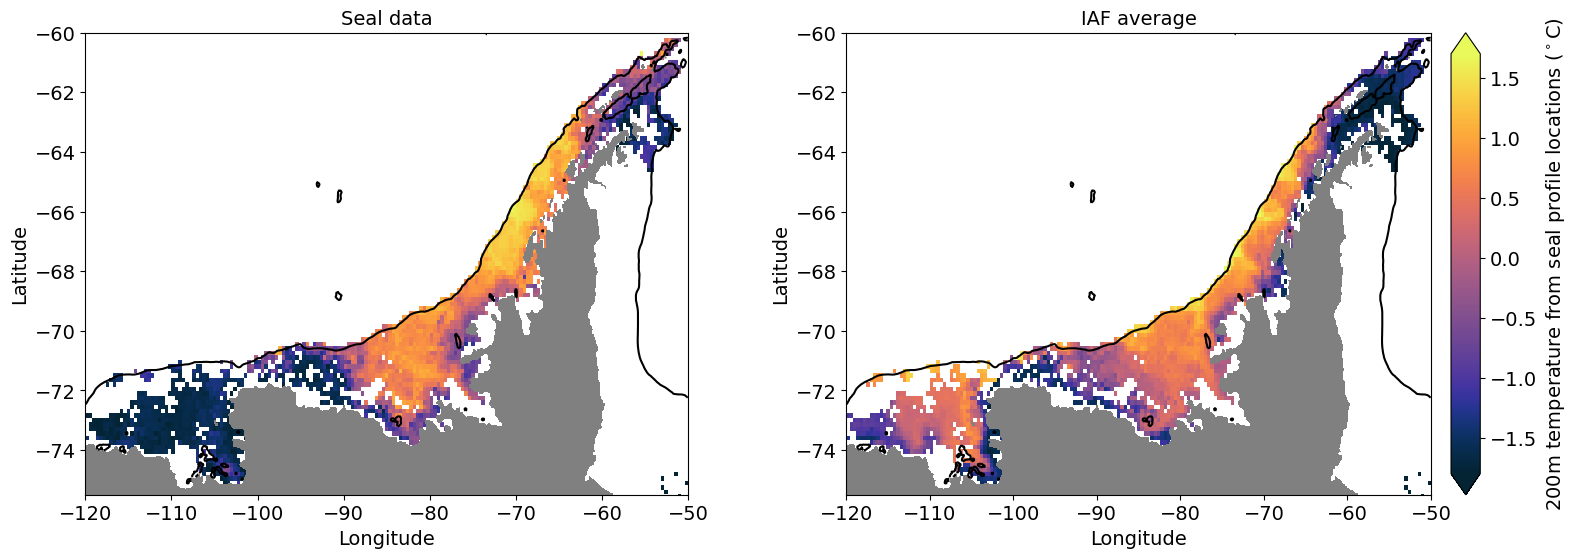

In [9]:
# plot 200m slice:
fontsize = 14
depth_slice = 200

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sc = plt.pcolormesh(binned_meop_temp.lon_bin,binned_meop_temp.lat_bin,binned_meop_temp,cmap=cmocean.thermal,vmin=-1.8,vmax=1.7)
#pc = plt.pcolormesh(binned_iaf_temp.lon_bin,binned_iaf_temp.lat_bin,binned_iaf_temp,cmap=cmocean.thermal,vmin=-1.8,vmax=1.7)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.xlim(-120,-50)
plt.ylim(-75.5,-60)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)
plt.title('Seal data',fontsize=fontsize)
#plt.title('IAF average',fontsize=fontsize)

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
cax.axis('off')

plt.subplot(1,2,2)
pc = plt.pcolormesh(binned_iaf_temp.lon_bin,binned_iaf_temp.lat_bin,binned_iaf_temp,cmap=cmocean.thermal,vmin=-1.8,vmax=1.7)
#pc = plt.pcolormesh(binned_ryf_temp.lon_bin,binned_ryf_temp.lat_bin,binned_ryf_temp,cmap=cmocean.thermal,vmin=-1.8,vmax=1.7)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.xlim(-120,-50)
plt.ylim(-75.5,-60)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)
#plt.title('RYF climatology',fontsize=fontsize)
plt.title('IAF average',fontsize=fontsize)

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'both')
cbar.set_label(str(depth_slice)+'m temperature from seal profile locations ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

#figure_path = figdir+'/binned_IAF_RYF_temp_map_'+str(depth_slice)+'m.png'
#figure_path = figdir+'/binned_seal_RYF_temp_map_'+str(depth_slice)+'m.png'
figure_path = figdir+'/binned_seal_IAF_temp_map_'+str(depth_slice)+'m.png'
#plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

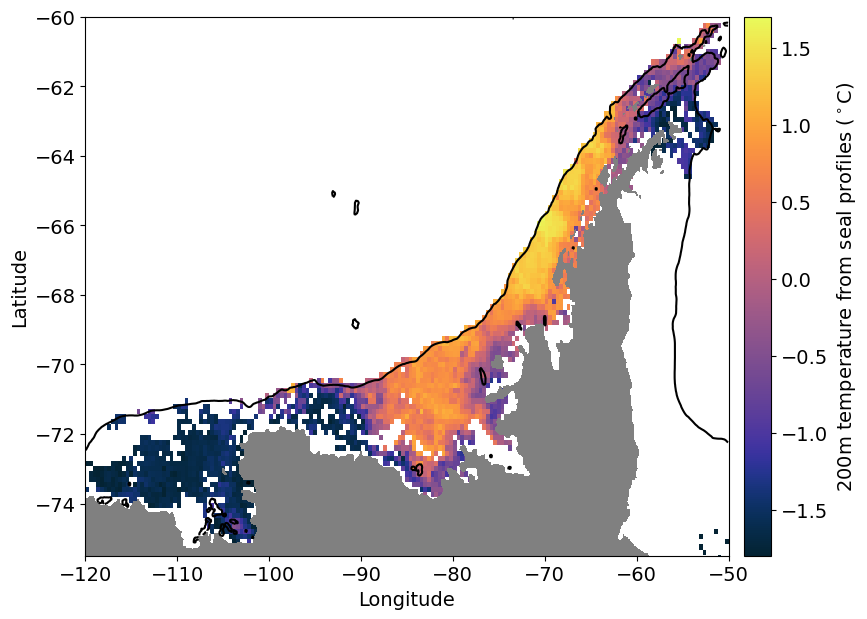

In [172]:
# plot 200m slice:
fontsize = 14
depth_slice = 200

plt.figure(figsize=(10,7))
sc = plt.pcolormesh(binned_meop_temp.lon_bin,binned_meop_temp.lat_bin,binned_meop_temp,cmap=cmocean.thermal,vmin=-1.8,vmax=1.7)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.xlim(-120,-50)
plt.ylim(-75.5,-60)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)

figure_path = figdir+'/binned_seal_temp_map_'+str(depth_slice)+'m.png'
plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

## Compare with Pathenet et al. 2021 climatology:

In [210]:
filepath = '/g/data/ik11/observations/Southern_Ocean_Climatology_PauthenetETAL2021/TS_Climato_Antarctic60S.nc'
climatology_data = xr.open_dataset(filepath)
climatology_temp = climatology_data.Temp

In [212]:
# select 200m depth:
climatology_temp = climatology_temp.sel(depth=200,method='nearest').transpose('time','lat','lon')

In [214]:
# get IAF climatology to compare:

level = 200
first_year = '2005'
last_year = '2015'
start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

temp_cycle3 = cc.querying.getvar(cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_cycle3 = temp_cycle3.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=level,method='nearest')
temp_cycle3 = temp_cycle3.groupby('time.month').mean('time')
temp_cycle3 = temp_cycle3.load()

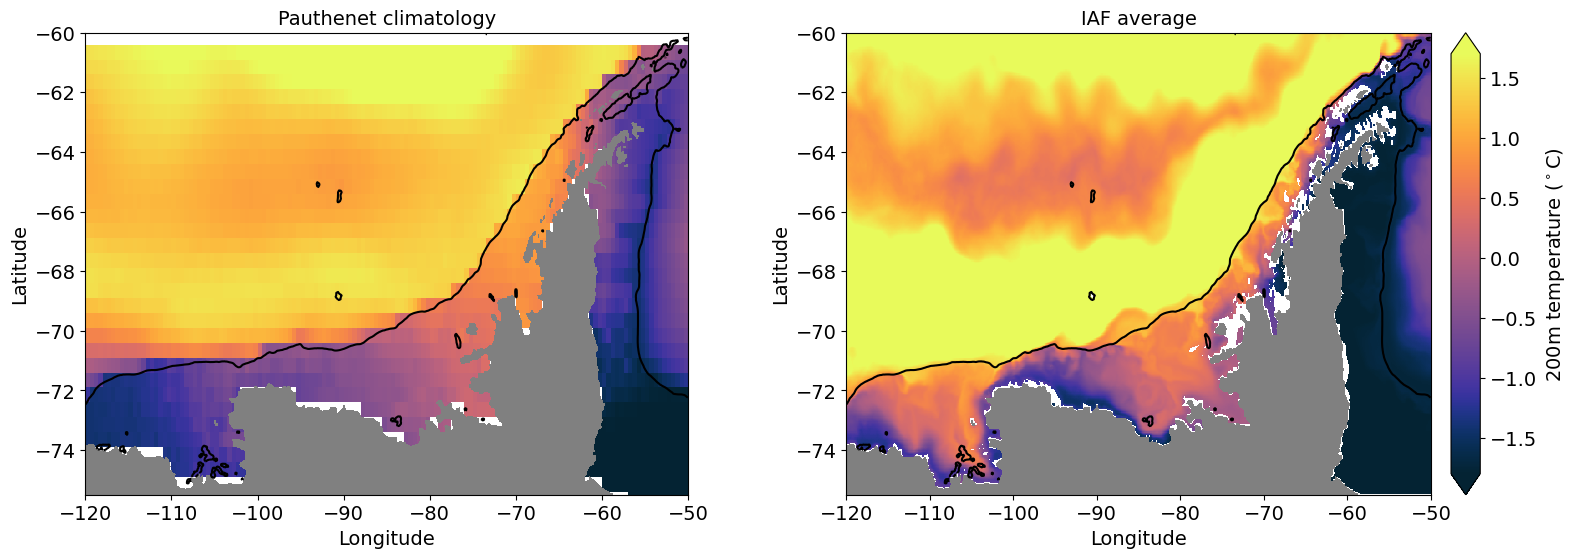

In [217]:
# compare annual mean:
fontsize = 14


climatology_mean = climatology_temp.mean('time')
iaf_mean = temp_cycle3.mean('month')

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sc = plt.pcolormesh(climatology_mean.lon,climatology_mean.lat,climatology_mean,cmap=cmocean.thermal,vmin=-1.8,vmax=1.7)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.xlim(-120,-50)
plt.ylim(-75.5,-60)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)
plt.title('Pauthenet climatology',fontsize=fontsize)

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
cax.axis('off')

plt.subplot(1,2,2)
pc = plt.pcolormesh(iaf_mean.xt_ocean,iaf_mean.yt_ocean,iaf_mean,cmap=cmocean.thermal,vmin=-1.8,vmax=1.7)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.xlim(-120,-50)
plt.ylim(-75.5,-60)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)
plt.title('IAF average',fontsize=fontsize)

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'both')
cbar.set_label(str(depth_slice)+'m temperature ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

#figure_path = figdir+'/binned_IAF_RYF_temp_map_'+str(depth_slice)+'m.png'
#figure_path = figdir+'/binned_seal_RYF_temp_map_'+str(depth_slice)+'m.png'
figure_path = figdir+'/binned_seal_IAF_temp_map_'+str(depth_slice)+'m.png'
#plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')